In [1]:
import os

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Contents
1. <a href="#section_1">Import Data</a>
2. <a href="#section_2">Dealing with Missing Values</a>
3. <a href="#section_3">Scaling Numerical Data and Encoding Categorical Data</a>
4. <a href="#section_4">Split Train and Test Sets</a>
5. <a href="#section_5">Resample Train Dataset</a>

<a id="section_1"></a>
#### Import Data

In [2]:
root_dir = os.getcwd()

In [3]:
train_ds = pd.read_csv(os.path.join(root_dir, "trainfile.csv"))
predict_ds = pd.read_csv(os.path.join(root_dir, "testfile.csv"))

<a id="section_2"></a>
#### Dealing with Missing Values

In [5]:
def find_nullvalue_cols(dataframe):
    """
    This function is to output a list of column names that the columns in the dataframe have null
    values.
    """

    nullvalue_cols_list = [col_name for col_name in dataframe.columns if dataframe[col_name].isna().sum()>0]
    full_cols_list = dataframe.columns.tolist()
    for col in full_cols_list:
        
        # Apart from checking if columns have null/missing values,
        # it is also better to check unique values of each column
        # in case some null values are in str type, such as "NONE", "none" or "None".
        # Above none values cannot be detected by pd.isna or pd.isnull.
        unique_value_list = dataframe[col].unique().tolist()
        if "None" and "NONE" and "none" in unique_value_list:
            nullvalue_cols_list.append(col)
        else:
            continue
    return nullvalue_cols_list

def unique_values(dataframe):
    """
    This function is to create a dictionary that keys are column names and
    values are columns' unique values. 
    """
    
    unique_values = {}
    for col_name in dataframe.columns.tolist():
        col_unique_values = dataframe[col_name].unique().tolist()
        unique_values[col_name] = col_unique_values
    
    return unique_values

def replace_nullvalues(dataframe, fill_value_list):
    """
    This function is to fill null/missing values of columns with your chosen values.
    """

    nullvalue_cols_list = find_nullvalue_cols(dataframe)
    for null_col_name_index in range(len(nullvalue_cols_list)):

        null_col_name = nullvalue_cols_list[null_col_name_index]
        fill_value = fill_value_list[null_col_name_index]
        dataframe[null_col_name].fillna(value=fill_value, inplace=True)

    return dataframe

In [ ]:
trainds_null_cols = find_nullvalue_cols(train_ds)
print(trainds_null_cols)

predds_null_cols = find_nullvalue_cols(predict_ds)
print(predds_null_cols)

In [ ]:
# Get a list of unique values of each columns for deciding what values can be used to replace
# null/missing values.
train_cols_uniquevalues = unique_values(train_ds)
pred_cols_uniquevalues = unique_values(predict_ds)

In [ ]:
trainds_fill_nullvalue_list = ["Unknown", "no_enrollment", "Unknown", "Other", 0, "Unknown", "Other", "never"]
train_ds = replace_nullvalues(train_ds, trainds_fill_nullvalue_list)
doublecheck_null_trainds = find_nullvalue_cols(train_ds)
print(doublecheck_null_trainds)

predds_fill_nullvalue_list = ["Unknown", "no_enrollment", "Unknown", "Other", 0, "Unknown", "Other", "never"]
predict_ds = replace_nullvalues(predict_ds, predds_fill_nullvalue_list)
doublecheck_null = find_nullvalue_cols(predict_ds)
print(doublecheck_null)

[]
[]


<a id="section_3"></a>
#### Scaling Numerical Data and Encoding Categorical Data
##### For dnn_model1 data:
As city and experience have more than 20 unique values, we will embed these unique values to
vectors when input data is fed in the model.
1. Step 1 Standardscaler.
    It is for columns: city_development_index, training_hours.
2. Step 2 One-hot encoding.
    It is for columns: from gender to last_new_job.
3. Step 3 Ordinal encoding.
    It is for columns: city, experience.

##### For dnn_model2 data:
The first three steps are the same as generating data for dnn_model1, but generating dnn_model2
will have an extra step that is to scale city and experience columns after their ordinal encoding.
1. Step 1 Standardscaler.
    It is for columns: city_development_index, training_hours.
2. Step 2 One-hot encoding.
    It is for columns: from gender to last_new_job.
3. Step 3 Ordinal encoding.
4. Step 4 Standardscaler.
    It is for columns: city, experience.

In [ ]:
# Change column positions in order to bulk preprocess columns
train_ds = train_ds[["enrollee_id", "city_development_index", "training_hours", 
                    "gender", "relevent_experience", "enrolled_university",
                    "education_level", "major_discipline", "company_size", 
                    "company_type", "last_new_job", "city", "experience", "target"]]

predict_ds = predict_ds[["enrollee_id", "city_development_index",
                    "training_hours", "gender", "relevent_experience",
                    "enrolled_university", "education_level",
                    "major_discipline", "company_size", "company_type", 
                    "last_new_job", "city", "experience"]]

In [ ]:
def scale_numerical_values(dataframe, scale_cols_list, scale_method="standarscale"):
    """
    This function is to scale numerical columns to standard normal distributed data.

    Args:
    scale_cols_list:a list containing columns names, which the columns need to be scaled.
    scale_method: default is standardscale, but can choose minmaxscale too.
    """
    data = dataframe[scale_cols_list]
    if scale_method == "standarscale":
        
        scale = preprocessing.StandardScaler()
        scaled_data = scale.fit_transform(data)
        # Drop original columns and add scaled columns back to the dataframe
        dataframe = dataframe.drop(columns=scale_cols_list)
        dataframe_index_list = dataframe.index.to_list()
        scaled_cols_df = pd.DataFrame(data=scaled_data,
                                    index=dataframe_index_list,
                                    columns=scale_cols_list)
        dataframe = pd.concat([dataframe, scaled_cols_df], axis=1)
    
    elif scale_method == "minmaxscale":
        
        scale = preprocessing.MinMaxScaler()
        scaled_data = scale.fit_transform(data)
        # drop original columns and add scaled columns back to the dataframe
        dataframe = dataframe.drop(columns=scale_cols_list)
        dataframe_index_list = dataframe.index.to_list()
        scaled_cols_df = pd.DataFrame(data=scaled_data,
                                    index=dataframe_index_list,
                                    columns=scale_cols_list)
        dataframe = pd.concat([dataframe, scaled_cols_df], axis=1)

    return dataframe

def encode_categorical_values(dataframe, encoding_cols_list, encoding_method="onehot"):
    """
    This function is to encode categorical data columns.

    Args:
    encoding_cols_list: a list containing column names, which the columns need to be encoded
    encoding_method: default is onehot encoding, but can choose ordinal encoding too.
    """
    data=dataframe[encoding_cols_list]
    if encoding_method == "onehot":

        encoder = preprocessing.OneHotEncoder()
        # this is a compressed matrix. Need to convert it to a numpy array
        encoding_data = encoder.fit_transform(data)
        encoding_data = encoding_data.toarray()
        # get new columns' names after one-hot encoding and convert it to a list
        encoded_cols_names = encoder.get_feature_names_out(encoding_cols_list)
        encoded_cols_names = encoded_cols_names.tolist()
        # drop original columns and add scaled columns back to the dataframe
        dataframe = dataframe.drop(columns=encoding_cols_list)
        dataframe_index_list = dataframe.index.to_list()
        encoded_cols_df = pd.DataFrame(data=encoding_data,
                                        index=dataframe_index_list,
                                        columns=encoded_cols_names)
        dataframe = pd.concat([dataframe, encoded_cols_df], axis=1)

    elif encoding_method == "ordinal":
        
        encoder = preprocessing.OrdinalEncoder()
        encoding_data = encoder.fit_transform(data)
        # drop original columns and add scaled columns back to the dataframe
        dataframe = dataframe.drop(columns=encoding_cols_list)
        dataframe_index_list = dataframe.index.to_list()
        encoded_cols_df = pd.DataFrame(data=encoding_data,
                                        index=dataframe_index_list,
                                        columns=encoding_cols_list)
        dataframe = pd.concat([dataframe, encoded_cols_df], axis=1)

    return dataframe

##### Step 1
Standardising scale columns "city_development_index", "training_hours".

In [ ]:
standardized_cols = ["city_development_index", "training_hours"]
train_ds = scale_numerical_values(train_ds, standardized_cols)
predict_ds = scale_numerical_values(predict_ds, standardized_cols)

##### Step 2
One-hot encoding columns "gender", ..., "last_new_job".

In [ ]:
onehot_cols = ["gender", "relevent_experience", "enrolled_university",
                "education_level", "major_discipline", "company_size",
                "company_type", "last_new_job"]
train_ds = encode_categorical_values(train_ds, onehot_cols)
predict_ds = encode_categorical_values(predict_ds, onehot_cols)

##### Step 3
Ordinal encode columns "city", "experience".

In [ ]:
ordinal_cols = ["city", "experience"]
# Some values in the "experience" column are object,
# so need to convert all values in encoding columns to the same datatype before encoding.
train_ds["experience"] = train_ds["experience"].apply(lambda x: str(x))
predict_ds["experience"] = predict_ds["experience"].apply(lambda x: str(x))

train_ds = encode_categorical_values(train_ds, ordinal_cols, encoding_method="ordinal")
predict_ds = encode_categorical_values(predict_ds, ordinal_cols, encoding_method="ordinal")

##### Step 4
Extra setp for generating data for dnn_model2.
Standarscale columns "city", "experience".

In [ ]:
# This process is to scale columns "city", "experience".
# It is for model2's dataset.
# Do not run this cell if it is for creating dataset for model1,
# because the ordinal encoded columns "city", "experience" are used in
# trainable embedding layers in model1. 
train_ds = scale_numerical_values(train_ds, ordinal_cols)
predict_ds = scale_numerical_values(predict_ds, ordinal_cols)

In [ ]:
# View preprocessed dataset.
predict_ds.head(5)

,enrollee_id,city_development_index,training_hours,gender_Female,gender_Male,gender_Other,gender_Unknown,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,...,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never,city,experience
0,32403,0.016126,-0.730319,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,69.0,20.0
1,9858,0.759860,0.548230,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,16.0
2,31806,-1.607295,-0.829946,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,55.0,21.0
3,27385,0.016126,-0.431437,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,22.0,3.0
4,27724,0.759860,0.116513,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,22.0


In [ ]:
# Create and save a prediction dataset.
predict_ds.drop(columns="enrollee_id", inplace=True)
predict_ds_arr = predict_ds.to_numpy()
np.savetxt(f"{root_dir}\\model2_data\\prediction_ds.txt", predict_ds_arr, delimiter=",")
# Save processed training data before splitting.
train_ds.to_csv(f"{root_dir}\\original_data\\model2_preprocessed_train.csv")

<a id="section_4"></a>
#### Split Train and Test Sets

In [ ]:
x_train, x_test = train_test_split(train_ds, test_size=0.2, shuffle=True, random_state=42)
print(type(x_train))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Create label data.
y_train = x_train["target"].to_numpy()
y_test = x_test["target"].to_numpy()
print(type(y_train))
print(y_train.shape) # Shape is (15326,)

# Need to reshape to a 2-d array before saving.
y_train_arr = y_train.reshape(y_train.shape[0], 1)
y_test_arr = y_test.reshape(y_test.shape[0], 1)

<class 'numpy.ndarray'>
(15326,)


In [ ]:
# Create train and test input data by dropping columns "enrollee_id", "target".
x_train.drop(columns=["enrollee_id", "target"], inplace=True)
x_train = x_train.to_numpy()

x_test.drop(columns=["enrollee_id", "target"], inplace=True)
x_test = x_test.to_numpy()

<a id="section_5"></a>
#### Resample Train Dataset
The dataset is imbalanced.
The minority class (label 1) to majority class (label 0) ratio is approximate 1:3.<br>
I will use two approachs to deal with this problem.<br>
1. It is to set class weights during model training. Please check result_check.ipynb.<br>
2. It is to oversample minority class of the input data. The oversampling is shown as
below.

class_0: 11501
class_1: 3825
Examples:
 Total: 15326
 class_1: 3825 (24.96% of total)



<BarContainer object of 2 artists>

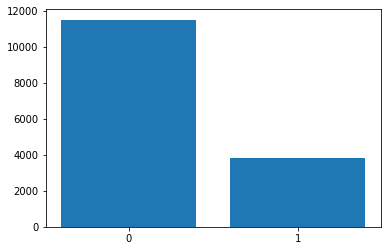

In [ ]:
class_0, class_1 = np.bincount(y_train.astype(int))
total = class_0 + class_1
print("class_0: {}".format(class_0))
print("class_1: {}".format(class_1))
print("Examples:\n Total: {}\n class_1: {} ({:.2f}% of total)\n".format(
    total, class_1, 100 * class_1 / total)
    )

plt.bar(["0", "1"], [class_0, class_1])

##### Resampling will use imbalanced-learn's RandomOverSampler or SMOTE

<BarContainer object of 2 artists>

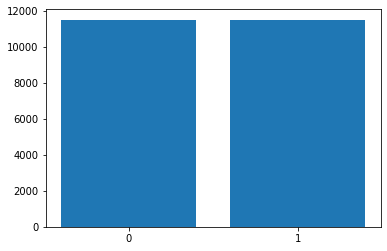

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(x_train, y_train)

plt.bar(["0", "1"], [y_ros[y_ros==0].shape[0], y_ros[y_ros==1].shape[0]])

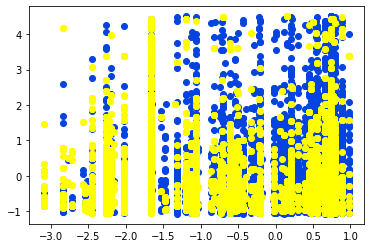

In [ ]:
colours = ["#0343DF", "#FFFF00"]
for l, c in zip(np.unique(y_ros), colours):
    plt.scatter(X_ros[y_ros==l, 0], X_ros[y_ros==l, 1], c=c)

<BarContainer object of 2 artists>

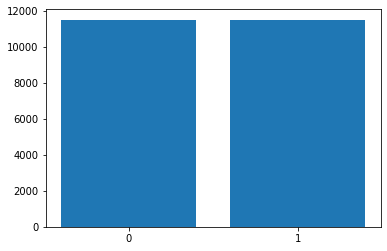

In [ ]:
from imblearn.over_sampling import SMOTE

smo = SMOTE(random_state=32)
X_smo, y_smo = smo.fit_resample(x_train, y_train)

plt.bar(["0", "1"], [y_smo[y_smo==0].shape[0], y_smo[y_smo==1].shape[0]])

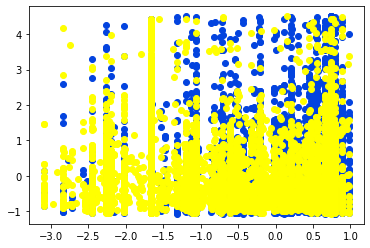

In [ ]:
colours = ["#0343DF", "#FFFF00"]
for l, c in zip(np.unique(y_smo), colours):
    plt.scatter(X_smo[y_smo==l, 0], X_smo[y_smo==l, 1], c=c)